**Loading in our dataset (Files avaliable in the shared google doc). Excel File came from UNICEF and the API and MetaData Files come from World Bank.**

In [2]:
import pandas as pd

# Install openpyxl for reading .xlsx files
!pip install openpyxl

# 1. Load all the datasets

# Mortality data (child deaths)
df_mortality = pd.read_csv(
    'API_SH.DYN.MORT_DS2_en_csv_v2_1121926.csv',
    skiprows=4
)

# Malaria prevention data (ITN coverage)
df_itn = pd.read_excel(
    'Child-Health-Coverage-Database-May-2022.xlsx',
    sheet_name='ITN'
)

# Country information (poverty/income levels)
df_metadata = pd.read_csv(
    'Metadata_Country_API_SH.DYN.MORT_DS2_en_csv_v2_1121926.csv'
)

# 2. Clean and prepare each dataset

# Convert years from columns to rows
df_mortality_long = df_mortality.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name='Year',
    value_name='Child_Mortality_Rate'
)
# Keep only valid years
df_mortality_long['Year'] = pd.to_numeric(df_mortality_long['Year'], errors='coerce')
df_mortality_long = df_mortality_long.dropna(subset=['Year', 'Child_Mortality_Rate'])
df_mortality_long['Year'] = df_mortality_long['Year'].astype(int)

# Keep key columns from ITN data
df_itn_clean = df_itn[['ISO', 'Year', 'National', 'Poorest', 'Richest']].copy()
df_itn_clean = df_itn_clean.rename(columns={
    'National': 'ITN_Coverage',
    'Poorest': 'ITN_Poorest',
    'Richest': 'ITN_Richest'
})

# Keep key country information
df_metadata_clean = df_metadata[['Country Code', 'Region', 'IncomeGroup']].copy()

# 3. Join the datasets together

# Step 1: Join mortality + prevention data
df_combined = pd.merge(
    df_mortality_long,
    df_itn_clean,
    left_on=['Country Code', 'Year'],
    right_on=['ISO', 'Year'],
    how='inner'  # Keep only countries with both mortality AND prevention data
)

# Step 2: Add country information (poverty/region data)
df_final = pd.merge(
    df_combined,
    df_metadata_clean,
    on='Country Code',
    how='left'
)

# 4. Final cleanup
# Remove any rows with missing critical data
df_final = df_final.dropna(subset=['Child_Mortality_Rate', 'ITN_Coverage'])
df_final = df_final.drop_duplicates(subset=['Country Code', 'Year'])


# Create useful columns for analysis
df_final['Wealth_Gap'] = df_final['ITN_Richest'] - df_final['ITN_Poorest']

# Select only the columns we need
final_columns = [
    'Country Name', 'Country Code', 'Year',
    'Child_Mortality_Rate',           # How many children die
    'ITN_Coverage',                   # Malaria prevention coverage
    'ITN_Poorest', 'ITN_Richest',     # Poverty indicators
    'Wealth_Gap',                     # Inequality measure
    'Region', 'IncomeGroup'           # Socioeconomic factors
]

df_final = df_final[final_columns]


The `df_final` DataFrame has been saved as `df_final.csv`.

In [3]:
df_final['IncomeGroup'] = df_final['IncomeGroup'].fillna('Lower middle income')
df_final = df_final.fillna({
    'ITN_Poorest': df_final['ITN_Poorest'].median(),
    'ITN_Richest': df_final['ITN_Richest'].median(),
    'Wealth_Gap': df_final['Wealth_Gap'].median()
})
df_final.isna().sum()

Country Name            0
Country Code            0
Year                    0
Child_Mortality_Rate    0
ITN_Coverage            0
ITN_Poorest             0
ITN_Richest             0
Wealth_Gap              0
Region                  0
IncomeGroup             0
dtype: int64

**Data Cleaning and Basic Visualization Phase**

In [4]:
print("DATA RANGE VALIDATION")
print("=" * 50)

# Define expected ranges for each variable
expected_ranges = {
    'Year': (2000, 2025),  # Based on your data context
    'Child_Mortality_Rate': (0, 300),  # 0-300 deaths/1000 births reasonable
    'ITN_Coverage': (0, 100),  # Percentage should be 0-100%
    'ITN_Poorest': (0, 100),   # Percentage should be 0-100%
    'ITN_Richest': (0, 100),   # Percentage should be 0-100%
    'Wealth_Gap': (-100, 100)  # Percentage points difference
}

# Check each column against expected ranges
for column, (min_expected, max_expected) in expected_ranges.items():
    actual_min = df_final[column].min()
    actual_max = df_final[column].max()

    print(f"\n📊 {column}:")
    print(f"   Expected: {min_expected} to {max_expected}")
    print(f"   Actual:   {actual_min:.1f} to {actual_max:.1f}")

    # Check for violations
    if actual_min < min_expected:
        print(f"   ⚠️  WARNING: Values below expected range!")
    if actual_max > max_expected:
        print(f"   ⚠️  WARNING: Values above expected range!")
    if actual_min >= min_expected and actual_max <= max_expected:
        print(f"   ✅ Range is VALID")

# Additional sanity checks
print(f"\n🔍 SANITY CHECKS:")
print(f"   No negative mortality rates: {(df_final['Child_Mortality_Rate'] >= 0).all()}")
print(f"   ITN coverage <= 100%: {(df_final['ITN_Coverage'] <= 100).all()}")

DATA RANGE VALIDATION

📊 Year:
   Expected: 2000 to 2025
   Actual:   2000.0 to 2021.0
   ✅ Range is VALID

📊 Child_Mortality_Rate:
   Expected: 0 to 300
   Actual:   8.3 to 278.2
   ✅ Range is VALID

📊 ITN_Coverage:
   Expected: 0 to 100
   Actual:   0.2 to 95.5
   ✅ Range is VALID

📊 ITN_Poorest:
   Expected: 0 to 100
   Actual:   0.2 to 95.0
   ✅ Range is VALID

📊 ITN_Richest:
   Expected: 0 to 100
   Actual:   0.2 to 92.1
   ✅ Range is VALID

📊 Wealth_Gap:
   Expected: -100 to 100
   Actual:   -50.8 to 45.0
   ✅ Range is VALID

🔍 SANITY CHECKS:
   No negative mortality rates: True
   ITN coverage <= 100%: True


In [5]:
import numpy as np
print("DATA TYPE VALIDATION")
print("=" * 50)

# Check current data types
print("Current Data Types:")
print(df_final.dtypes)
print("\n" + "-" * 50)

# Expected data types for each column
expected_types = {
    'Country Name': 'object',
    'Country Code': 'object',
    'Year': 'int64',
    'Child_Mortality_Rate': 'float64',
    'ITN_Coverage': 'float64',
    'ITN_Poorest': 'float64',
    'ITN_Richest': 'float64',
    'Wealth_Gap': 'float64',
    'Region': 'object',
    'IncomeGroup': 'object'
}

# Validate each column type
print("\n🔍 DATA TYPE VALIDATION:")
for column, expected_type in expected_types.items():
    actual_type = str(df_final[column].dtype)
    if actual_type == expected_type:
        print(f"✅ {column}: {actual_type} (CORRECT)")
    else:
        print(f"❌ {column}: {actual_type} (SHOULD BE {expected_type})")

# Additional format checks
print("\n🔍 ADDITIONAL FORMAT CHECKS:")
print(f"✅ Year values are integers: {df_final['Year'].apply(lambda x: x == int(x)).all()}")
print(f"✅ No infinity values: {df_final.select_dtypes(include=['float64', 'int64']).apply(lambda x: np.isfinite(x).all()).all()}")
print(f"✅ Country codes are 3 characters: {df_final['Country Code'].str.len().eq(3).all()}")
print(f"✅ No duplicate country-year pairs: {not df_final.duplicated(subset=['Country Code', 'Year']).any()}")

# Check for any remaining missing values
print(f"✅ No missing values: {df_final.isnull().sum().sum() == 0}")

# Verify categorical values are reasonable
print(f"\n🔍 CATEGORICAL VALUE CHECKS:")
print(f"Unique Regions: {df_final['Region'].nunique()} categories")
print(f"Unique IncomeGroups: {df_final['IncomeGroup'].nunique()} categories")
print(f"All IncomeGroups are valid: {set(df_final['IncomeGroup'].unique()) <= {'Low income', 'Lower middle income', 'Upper middle income', 'High income'}}")

DATA TYPE VALIDATION
Current Data Types:
Country Name             object
Country Code             object
Year                      int64
Child_Mortality_Rate    float64
ITN_Coverage            float64
ITN_Poorest             float64
ITN_Richest             float64
Wealth_Gap              float64
Region                   object
IncomeGroup              object
dtype: object

--------------------------------------------------

🔍 DATA TYPE VALIDATION:
✅ Country Name: object (CORRECT)
✅ Country Code: object (CORRECT)
✅ Year: int64 (CORRECT)
✅ Child_Mortality_Rate: float64 (CORRECT)
✅ ITN_Coverage: float64 (CORRECT)
✅ ITN_Poorest: float64 (CORRECT)
✅ ITN_Richest: float64 (CORRECT)
✅ Wealth_Gap: float64 (CORRECT)
✅ Region: object (CORRECT)
✅ IncomeGroup: object (CORRECT)

🔍 ADDITIONAL FORMAT CHECKS:
✅ Year values are integers: True
✅ No infinity values: True
✅ Country codes are 3 characters: True
✅ No duplicate country-year pairs: True
✅ No missing values: True

🔍 CATEGORICAL VALUE CHECKS:
Un

In [6]:
print("DUPLICATE CHECK")
print("=" * 40)

# Check for completely identical rows (all columns)
full_duplicates = df_final.duplicated().sum()
print(f"Complete duplicate rows: {full_duplicates}")

# Check for country-year duplicates (most important for time series analysis)
country_year_duplicates = df_final.duplicated(subset=['Country Code', 'Year']).sum()
print(f"Duplicate country-year combinations: {country_year_duplicates}")

# If duplicates found, show them
if country_year_duplicates > 0:
    print(f"\n🔍 DUPLICATE COUNTRY-YEAR ENTRIES:")
    duplicates = df_final[df_final.duplicated(subset=['Country Code', 'Year'], keep=False)]
    print(duplicates.sort_values(['Country Code', 'Year']).head(10))

DUPLICATE CHECK
Complete duplicate rows: 0
Duplicate country-year combinations: 0


COMPREHENSIVE CORRELATION ANALYSIS

📊 PEARSON CORRELATION MATRIX:
                      Child_Mortality_Rate  ITN_Coverage  ITN_Poorest  \
Child_Mortality_Rate                 1.000        -0.321       -0.250   
ITN_Coverage                        -0.321         1.000        0.856   
ITN_Poorest                         -0.250         0.856        1.000   
ITN_Richest                         -0.190         0.839        0.715   
Wealth_Gap                           0.227        -0.113       -0.387   
Year                                -0.422         0.671        0.533   

                      ITN_Richest  Wealth_Gap   Year  
Child_Mortality_Rate       -0.190       0.227 -0.422  
ITN_Coverage                0.839      -0.113  0.671  
ITN_Poorest                 0.715      -0.387  0.533  
ITN_Richest                 1.000       0.311  0.511  
Wealth_Gap                  0.311       1.000 -0.172  
Year                        0.511      -0.172  1.000  


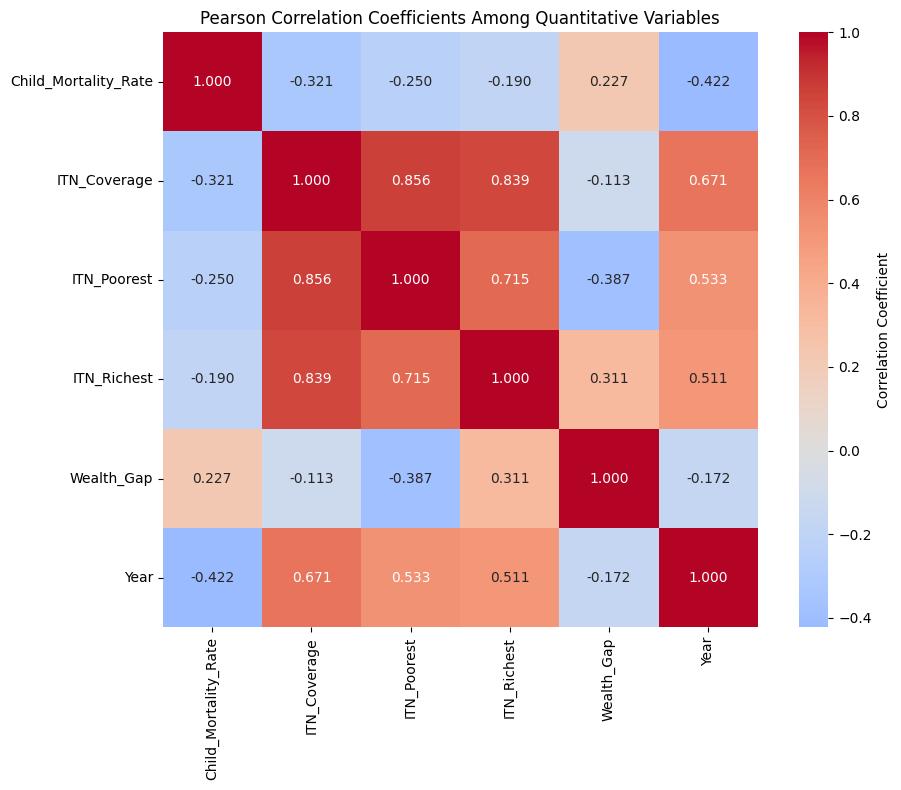


🔍 HIGHLY CORRELATED PAIRS (|r| > 0.5):
  ITN_Coverage              vs ITN_Poorest              : r =   0.856
  ITN_Coverage              vs ITN_Richest              : r =   0.839
  ITN_Coverage              vs Year                     : r =   0.671
  ITN_Poorest               vs ITN_Richest              : r =   0.715
  ITN_Poorest               vs Year                     : r =   0.533
  ITN_Richest               vs Year                     : r =   0.511

📈 BEST FIT ANALYSIS FOR HIGHLY CORRELATED PAIRS (|r| > 0.5):

ITN_Coverage vs ITN_Poorest:
  Pearson r:    0.856
  Best fit:     linear
  R²:           0.733
  Coefficients: [0.79704789 7.32483167]


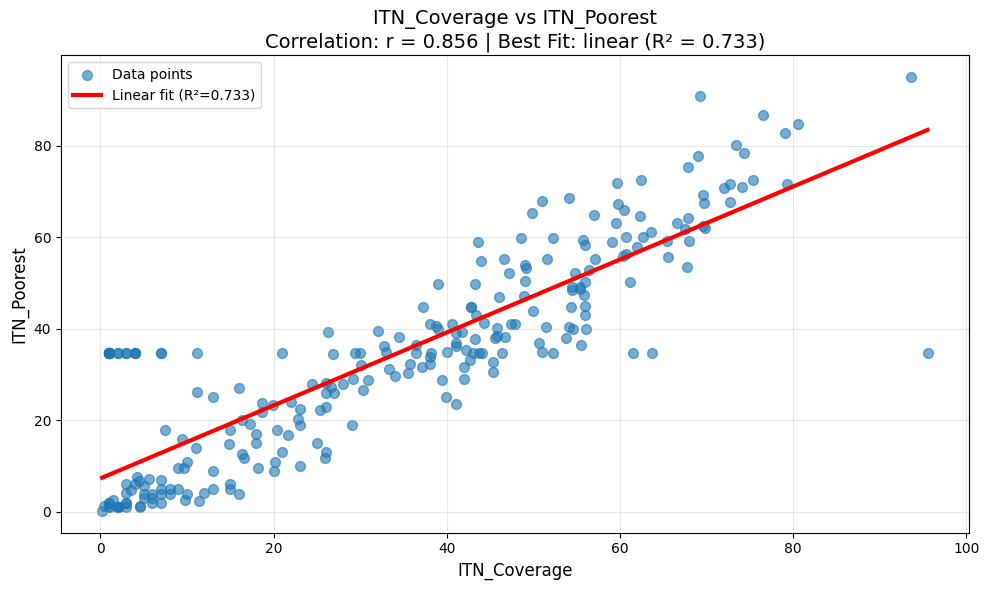


ITN_Coverage vs ITN_Richest:
  Pearson r:    0.839
  Best fit:     linear
  R²:           0.703
  Coefficients: [0.78356231 7.99632195]


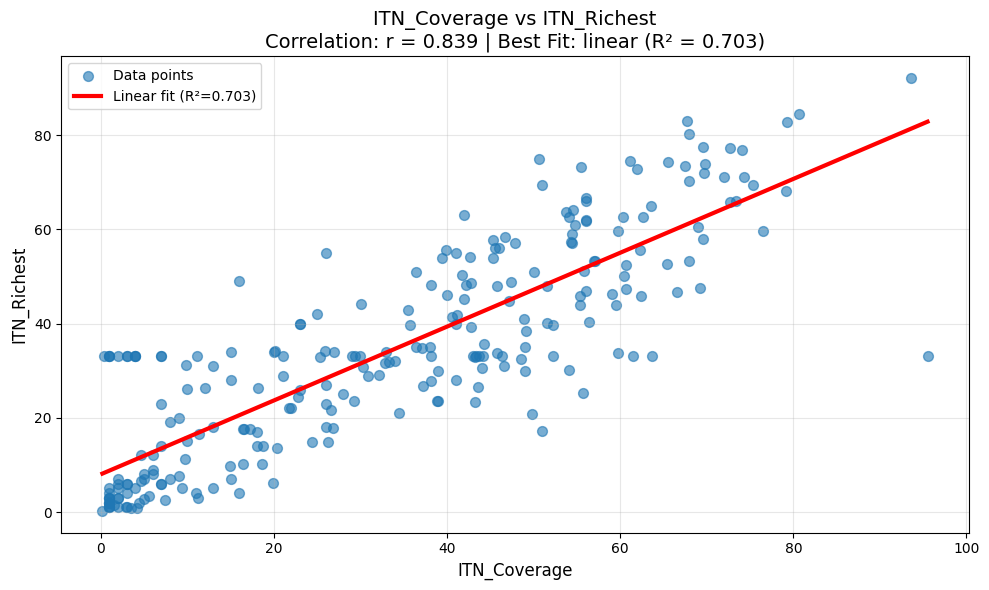


ITN_Coverage vs Year:
  Pearson r:    0.671
  Best fit:     linear
  R²:           0.450
  Coefficients: [1.61808466e-01 2.00523836e+03]


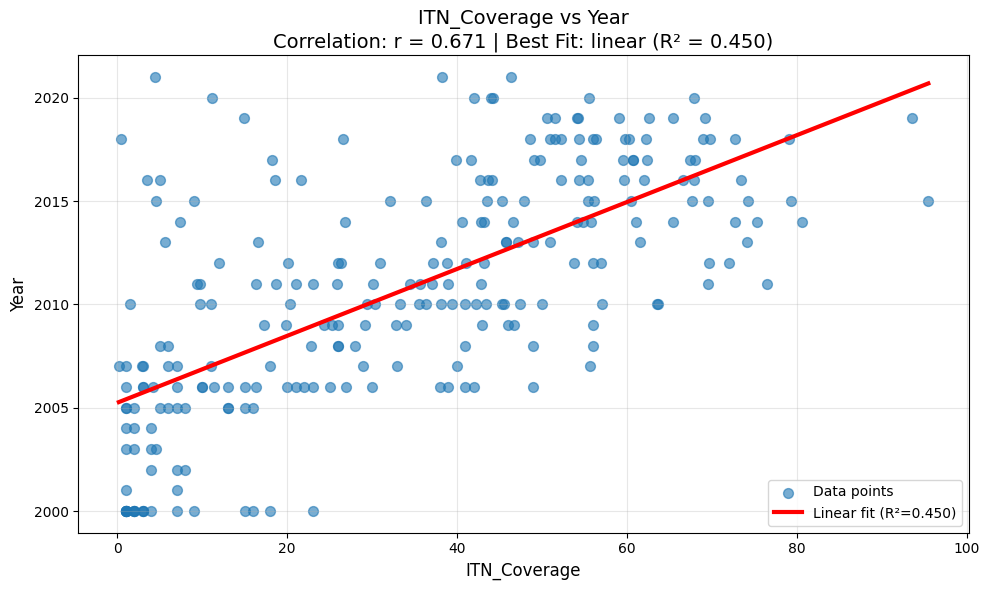


ITN_Poorest vs ITN_Richest:
  Pearson r:    0.715
  Best fit:     linear
  R²:           0.511
  Coefficients: [0.71760238 9.89423827]


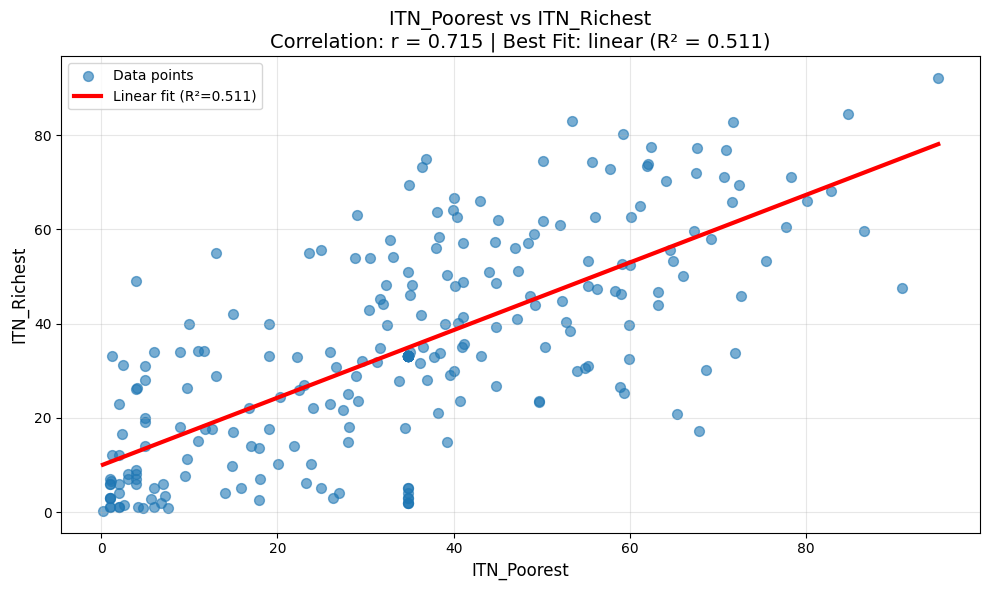


ITN_Poorest vs Year:
  Pearson r:    0.533
  Best fit:     linear
  R²:           0.284
  Coefficients: [1.37907446e-01 2.00598262e+03]


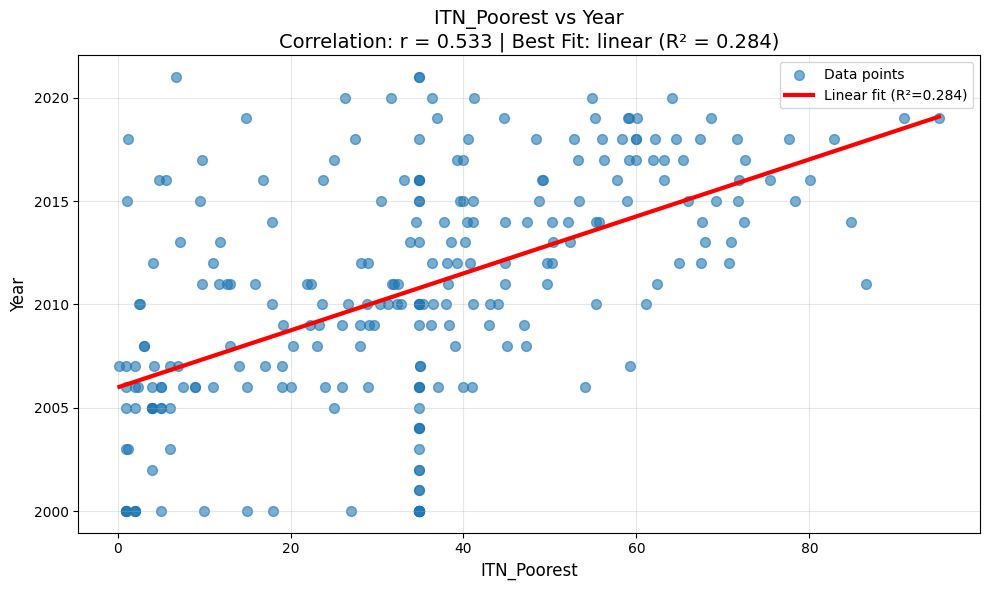


ITN_Richest vs Year:
  Pearson r:    0.511
  Best fit:     linear
  R²:           0.261
  Coefficients: [1.31880422e-01 2.00616076e+03]


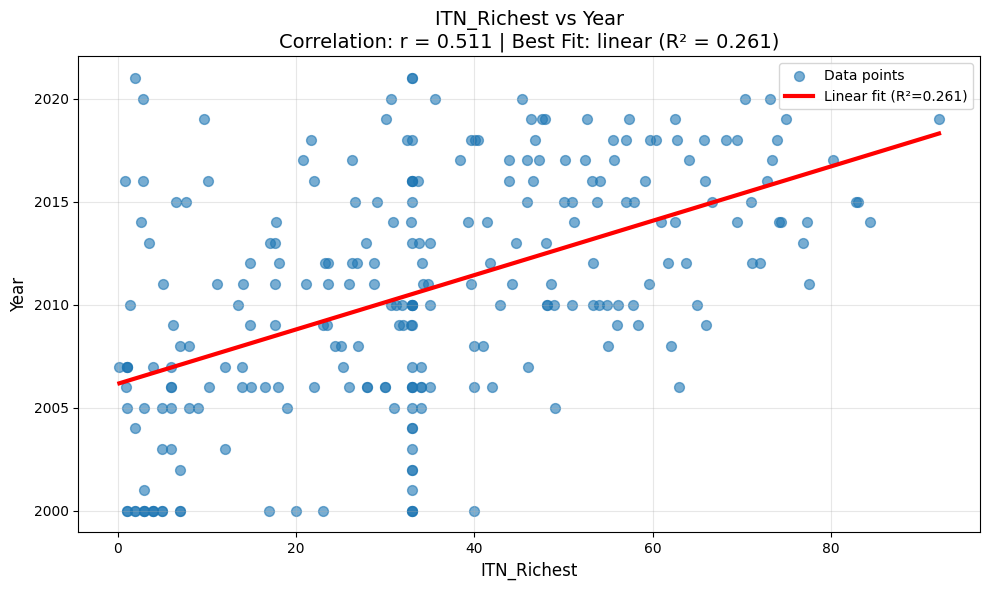


KEY RELATIONSHIPS FOR RESEARCH QUESTION

🎯 CRITICAL RELATIONSHIPS FOR MALARIA PREVENTION ANALYSIS:
  Child_Mortality_Rate      vs ITN_Coverage             : r =  -0.321 *
    → Best fit: linear (R² = 0.103)
  Child_Mortality_Rate      vs ITN_Poorest              : r =  -0.250 
  Child_Mortality_Rate      vs ITN_Richest              : r =  -0.190 
  Child_Mortality_Rate      vs Wealth_Gap               : r =   0.227 

STATISTICAL SUMMARY
Total quantitative variables: 6
Highly correlated pairs (|r| > 0.5): 6
Dataset size: 251 observations

Best fit distribution:
  linear: 6 relationships


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

print("COMPREHENSIVE CORRELATION ANALYSIS")
print("=" * 60)

# Select quantitative columns
quantitative_columns = ['Child_Mortality_Rate', 'ITN_Coverage', 'ITN_Poorest',
                       'ITN_Richest', 'Wealth_Gap', 'Year']
df_quant = df_final[quantitative_columns]

# 1. Calculate Pearson Correlation Matrix
print("\n📊 PEARSON CORRELATION MATRIX:")
correlation_matrix = df_quant.corr()
print(correlation_matrix.round(3))

# 2. Visualize Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pearson Correlation Coefficients Among Quantitative Variables')
plt.tight_layout()
plt.show()

# 3. Improved function for best fit determination
def find_best_fit(x, y, x_name, y_name):
    """
    Determine best fit with preference for simpler models
    Returns: best_fit_type, r2_score, fit_parameters
    """
    # Clean data
    valid_mask = ~(x.isna() | y.isna())
    x_clean = x[valid_mask]
    y_clean = y[valid_mask]

    if len(x_clean) < 10:
        return "Insufficient data", 0, None

    x_vals = x_clean.values
    y_vals = y_clean.values

    # Fit models
    fits = {}
    r2_scores = {}

    # Linear fit (degree 1)
    fits['linear'] = np.polyfit(x_vals, y_vals, 1)
    y_pred_linear = np.polyval(fits['linear'], x_vals)
    r2_scores['linear'] = r2_score(y_vals, y_pred_linear)

    # Quadratic fit (degree 2) - only if we have enough data
    if len(x_clean) >= 15:
        fits['quadratic'] = np.polyfit(x_vals, y_vals, 2)
        y_pred_quad = np.polyval(fits['quadratic'], x_vals)
        r2_scores['quadratic'] = r2_score(y_vals, y_pred_quad)
    else:
        r2_scores['quadratic'] = -np.inf

    # Cubic fit (degree 3) - only if we have plenty of data
    if len(x_clean) >= 20:
        fits['cubic'] = np.polyfit(x_vals, y_vals, 3)
        y_pred_cubic = np.polyval(fits['cubic'], x_vals)
        r2_scores['cubic'] = r2_score(y_vals, y_pred_cubic)
    else:
        r2_scores['cubic'] = -np.inf

    # Determine best fit with preference for simplicity
    best_fit = 'linear'
    best_r2 = r2_scores['linear']

    # Only choose quadratic if it's significantly better
    if r2_scores['quadratic'] > r2_scores['linear'] + 0.03:  # 3% improvement threshold
        best_fit = 'quadratic'
        best_r2 = r2_scores['quadratic']

        # Only choose cubic if it's significantly better than quadratic
        if r2_scores['cubic'] > r2_scores['quadratic'] + 0.02:  # 2% improvement threshold
            best_fit = 'cubic'
            best_r2 = r2_scores['cubic']

    return best_fit, best_r2, fits.get(best_fit)

# 4. Identify highly correlated pairs (|r| > 0.5)
print("\n🔍 HIGHLY CORRELATED PAIRS (|r| > 0.5):")
high_corr_pairs = []
threshold = 0.5

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr))
            print(f"  {col1:25} vs {col2:25}: r = {corr:7.3f}")

# 5. Analyze best fits for highly correlated pairs
print(f"\n📈 BEST FIT ANALYSIS FOR HIGHLY CORRELATED PAIRS (|r| > {threshold}):")
print("=" * 70)

if not high_corr_pairs:
    print("No highly correlated pairs found.")
else:
    for col1, col2, corr in high_corr_pairs:
        best_fit, best_r2, fit_params = find_best_fit(df_quant[col1], df_quant[col2], col1, col2)

        print(f"\n{col1} vs {col2}:")
        print(f"  Pearson r:    {corr:.3f}")
        print(f"  Best fit:     {best_fit}")
        print(f"  R²:           {best_r2:.3f}")

        if fit_params is not None:
            print(f"  Coefficients: {fit_params}")

        # Create visualization
        plt.figure(figsize=(10, 6))

        # Scatter plot
        plt.scatter(df_quant[col1], df_quant[col2], alpha=0.6, s=50, label='Data points')

        # Plot best fit line
        if best_fit != "Insufficient data":
            x_range = np.linspace(df_quant[col1].min(), df_quant[col1].max(), 100)

            if best_fit == 'linear':
                y_fit = np.polyval(fit_params, x_range)
                plt.plot(x_range, y_fit, 'r-', linewidth=3,
                        label=f'Linear fit (R²={best_r2:.3f})')
            elif best_fit == 'quadratic':
                y_fit = np.polyval(fit_params, x_range)
                plt.plot(x_range, y_fit, 'r-', linewidth=3,
                        label=f'Quadratic fit (R²={best_r2:.3f})')
            elif best_fit == 'cubic':
                y_fit = np.polyval(fit_params, x_range)
                plt.plot(x_range, y_fit, 'r-', linewidth=3,
                        label=f'Cubic fit (R²={best_r2:.3f})')

        plt.xlabel(col1, fontsize=12)
        plt.ylabel(col2, fontsize=12)
        plt.title(f'{col1} vs {col2}\nCorrelation: r = {corr:.3f} | Best Fit: {best_fit} (R² = {best_r2:.3f})',
                 fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 6. Summary of key relationships for research question
print("\n" + "=" * 70)
print("KEY RELATIONSHIPS FOR RESEARCH QUESTION")
print("=" * 70)

# Check the most important relationships for malaria prevention analysis
critical_relationships = [
    ('Child_Mortality_Rate', 'ITN_Coverage'),
    ('Child_Mortality_Rate', 'ITN_Poorest'),
    ('Child_Mortality_Rate', 'ITN_Richest'),
    ('Child_Mortality_Rate', 'Wealth_Gap')
]

print("\n🎯 CRITICAL RELATIONSHIPS FOR MALARIA PREVENTION ANALYSIS:")
for col1, col2 in critical_relationships:
    if col1 in df_quant.columns and col2 in df_quant.columns:
        corr = df_quant[col1].corr(df_quant[col2])
        significance = "***" if abs(corr) > 0.7 else "**" if abs(corr) > 0.5 else "*" if abs(corr) > 0.3 else ""

        print(f"  {col1:25} vs {col2:25}: r = {corr:7.3f} {significance}")

        if abs(corr) > 0.3:  # Analyze if moderately correlated
            best_fit, best_r2, _ = find_best_fit(df_quant[col1], df_quant[col2], col1, col2)
            print(f"    → Best fit: {best_fit} (R² = {best_r2:.3f})")

# 7. Final statistical summary
print("\n" + "=" * 70)
print("STATISTICAL SUMMARY")
print("=" * 70)
print(f"Total quantitative variables: {len(quantitative_columns)}")
print(f"Highly correlated pairs (|r| > {threshold}): {len(high_corr_pairs)}")
print(f"Dataset size: {len(df_quant)} observations")

# Count of best fit types used
if high_corr_pairs:
    fit_types = []
    for col1, col2, corr in high_corr_pairs:
        best_fit, _, _ = find_best_fit(df_quant[col1], df_quant[col2], col1, col2)
        fit_types.append(best_fit)

    fit_counts = pd.Series(fit_types).value_counts()
    print(f"\nBest fit distribution:")
    for fit_type, count in fit_counts.items():
        print(f"  {fit_type}: {count} relationships")

**Main Visuals used for this Project**

World Map of CM rates, Scatter Plot of ITN Coverage vs Child Mortality by Income Group, Stacked Bar Chart of ITN Coverage per Country by Rich vs Poor Economic Status, ITN Coverage (specifically ITN_Poorest because we care about assigning the correct treatments to poor countries) and Wealth Gap on Child Mortality Rate by different Regions of the World, Wealth Gap on Child Mortality Rate but by Income Groups, and Random Forest Feature Importance Chart and Brier Score Evaluation to handle and reduce misclassification since that is more important to us than pure accuracy or other ranking metrics.

In [10]:
# Install geopandas if not already installed
!pip install geopandas
!pip install folium

import geopandas as gpd
import pandas as pd
import folium

# --- Load shapefile (Natural Earth) ---
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)

# --- Merge with malaria dataset ---
world = world.rename(columns={"ISO_A3": "Country Code"})
merged = world.merge(df_final, on="Country Code", how="left")

# If values look like 0–10, multiply by 1000 to convert from fraction/percent to per 1,000
if merged["Child_Mortality_Rate"].max() < 10:
    merged["Child_Mortality_Rate"] = merged["Child_Mortality_Rate"] * 1000

# --- Create Folium map centered on Africa/Asia ---
m = folium.Map(location=[0, 20], zoom_start=2, tiles="cartodb positron")

# --- Choropleth (Child Mortality Rate per 1000 live births) ---
folium.Choropleth(
    geo_data=merged,
    name="Child Mortality Rate",
    data=merged,
    columns=["Country Code", "Child_Mortality_Rate"],
    key_on="feature.properties.Country Code",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="lightgray",
    legend_name="Child Mortality Rate (per 1,000 live births)",
).add_to(m)

# --- Interactive popups ---
for _, row in merged.iterrows():
    if pd.notnull(row["geometry"]):
        popup_text = (
            f"<b>Country:</b> {row['Country Name']}<br>"
            f"<b>ITN Coverage:</b> {row['ITN_Coverage']:.1f}%<br>"
            f"<b>Child Mortality Rate:</b> {row['Child_Mortality_Rate']:.1f} per 1,000 live births<br>"
            f"(≈ {row['Child_Mortality_Rate']/10:.1f}%)"
        )
        geo_center = row["geometry"].centroid.coords[0][::-1]
        folium.Marker(
            location=geo_center,
            popup=folium.Popup(popup_text, max_width=300),
        ).add_to(m)

# --- Layer control + Save ---
folium.LayerControl().add_to(m)
m.save("malaria_ITN_childmortality_map.html")

# --- Display map ---
m

In [11]:
import plotly.express as px

df_plot = df_final.copy()


# Create scatter plot
fig = px.scatter(
    df_plot,
    x='ITN_Coverage',
    y='Child_Mortality_Rate',
    color='IncomeGroup',
    hover_data={
        'Country Name': True,
        'ITN_Poorest': True,
        'ITN_Richest': True,
        'Wealth_Gap': True,
        'ITN_Coverage': ':.1f',
        'Child_Mortality_Rate': ':.1f'
    },
    labels={
        'ITN_Coverage': 'ITN Coverage (%)',
        'Child_Mortality_Rate': 'Child Mortality Rate (per 1,000 live births)'
    },
    title='Child Mortality vs ITN Coverage by Country and Income Group',
    size_max=15
)

# Enable interactive features
fig.update_layout(
    dragmode='pan',       # allows panning
    hovermode='closest',  # shows hover info for nearest point
    legend_title_text='Income Group'
)

# Enable box/lasso selection for filtering
fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))

# Show the interactive figure
fig.show()


In [12]:
import altair as alt
import pandas as pd

# Melt dataframe for poorest vs richest ITN coverage
df_bar = df_final.melt(
    id_vars=['Country Name', 'IncomeGroup', 'Child_Mortality_Rate'],
    value_vars=['ITN_Poorest', 'ITN_Richest'],
    var_name='Economic Status',
    value_name='ITN Coverage'
)

df_bar['Economic Status'] = df_bar['Economic Status'].replace({
    'ITN_Poorest': 'Poorest',
    'ITN_Richest': 'Richest'
})

# Altair bar chart: each country gets a bar, colored by economic status
chart = alt.Chart(df_bar).mark_bar().encode(
    x=alt.X('Country Name:N', sort=None, title='Country'),
    y=alt.Y('ITN Coverage:Q', title='ITN Coverage (%)'),
    color=alt.Color('Economic Status:N', title='Economic Status'),
    tooltip=[
        alt.Tooltip('Country Name:N', title='Country'),
        alt.Tooltip('IncomeGroup:N', title='Income Group'),
        alt.Tooltip('ITN Coverage:Q', title='ITN Coverage (%)'),
        alt.Tooltip('Child_Mortality_Rate:Q', title='Child Mortality Rate (per 1,000)')
    ]
).interactive()

chart.properties(
    width=800,
    height=400,
    title='ITN Coverage per Country by Economic Status'
)


alt.Chart(...)

In [24]:
import altair as alt
import pandas as pd

df_alt = df_final.copy()


brush = alt.selection_interval()
# A color palette with 20 distinct colors for regions
region_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

scatter_itn = alt.Chart(df_alt).mark_circle(size=80).encode(
    x=alt.X('ITN_Poorest:Q', title='ITN Coverage (Poorest %)'),
    y=alt.Y('Child_Mortality_Rate:Q', title='Child Mortality Rate (per 1,000)'),
    color=alt.Color('Region:N', scale={'range': region_colors[:df_alt['Region'].nunique()]}), # Use enough colors for unique regions
    tooltip=[
        'Country Name:N', 'IncomeGroup:N',
        'ITN_Poorest:Q', 'Child_Mortality_Rate:Q', 'Wealth_Gap:Q'
    ]
).add_params(brush).properties(width=400, height=400)

scatter_wealth = alt.Chart(df_alt).mark_circle(size=80).encode(
    x=alt.X('Wealth_Gap:Q', title='Wealth Gap (%)'),
    y=alt.Y('Child_Mortality_Rate:Q', title='Child Mortality Rate (per 1,000)'),
    color=alt.Color('Region:N', scale={'range': region_colors[:df_alt['Region'].nunique()]}),
    tooltip=[
        'Country Name:N', 'IncomeGroup:N',
        'ITN_Poorest:Q', 'Child_Mortality_Rate:Q', 'Wealth_Gap:Q'
    ]
).transform_filter(brush).properties(width=400, height=400)

linked_chart = alt.hconcat(scatter_itn, scatter_wealth).properties(
    title='Effect of ITN Coverage (Poorest) and Wealth Gap on Child Mortality Rates'
)

linked_chart


alt.HConcatChart(...)

In [25]:
import altair as alt
import pandas as pd

# Assume df_final is the DataFrame containing your data
# We'll rename it here for clarity within the function
df_alt = df_final.copy()

# A color palette with 10 distinct colors for income groups
income_group_colors = ['#4C78A8', '#F58518', '#E45756', '#72B7B2', '#54A24B', '#EECA3B', '#B279A2', '#FF9DA7', '#9D755D', '#BAB0AC']

# 1. Define the selection parameter
# This creates a selection that filters based on the 'IncomeGroup' field (the color)
selection = alt.selection_point(
    fields=['IncomeGroup'],  # Link the selection to the 'IncomeGroup' column
    bind='legend',           # Allow the selection to be controlled by clicking the legend
    name='IncomeGroup_Selector'
)

# 2. Create the Altair Scatter Plot
chart = alt.Chart(df_alt).mark_circle(size=80).encode(
    # X and Y Axes
    x=alt.X('Wealth_Gap:Q', title='Wealth Gap (%)'),
    y=alt.Y('Child_Mortality_Rate:Q', title='Child Mortality Rate (per 1,000 live births)'),

    # Color and Opacity controlled by selection
    color=alt.Color('IncomeGroup:N', title='Income Group', scale={'range': income_group_colors[:df_alt['IncomeGroup'].nunique()]}),

    # Tooltip (Hover Interaction)
    tooltip=[
        'Country Name:N',
        'IncomeGroup:N',
        alt.Tooltip('Wealth_Gap:Q', format='.1f'),
        alt.Tooltip('Child_Mortality_Rate:Q', format='.1f')
    ]
).add_params(
    selection # Apply the selection parameter to the chart
).properties(
    title='Interactive: Child Mortality Rate vs Wealth Gap by Income Group'
)

# Display the chart
chart

alt.Chart(...)

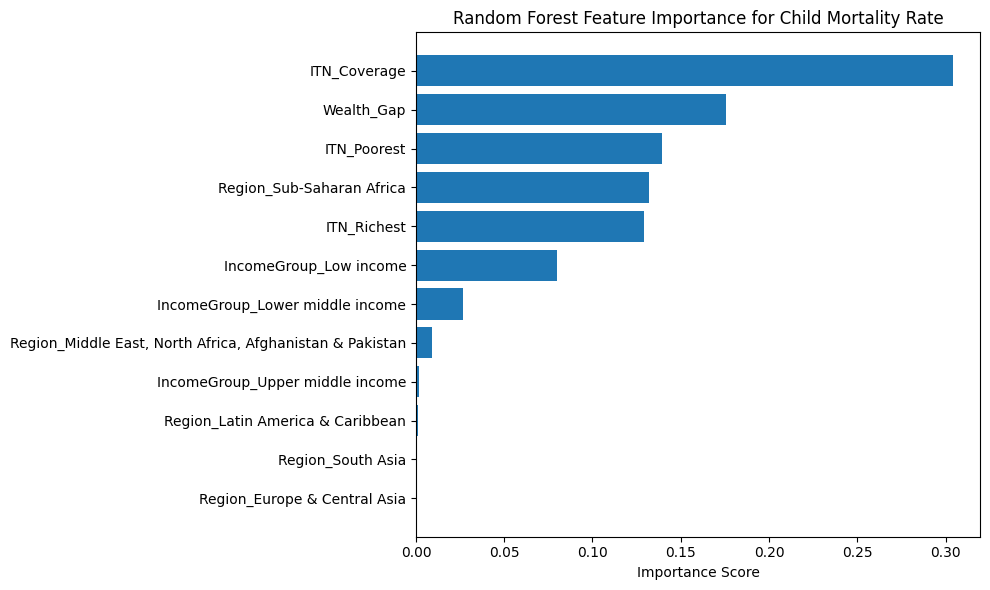

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Copy dataframe
df = df_final.copy()

# -----------------------
# 1. Select features + target
# -----------------------
X = df[['ITN_Coverage', 'ITN_Poorest', 'ITN_Richest',
        'Wealth_Gap', 'Region', 'IncomeGroup']]
y = df['Child_Mortality_Rate']

# -----------------------
# 2. Process categorical columns
# -----------------------
categorical_cols = ['Region', 'IncomeGroup']
numeric_cols = ['ITN_Coverage', 'ITN_Poorest', 'ITN_Richest', 'Wealth_Gap']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# -----------------------
# 3. Random Forest Regressor
# -----------------------
rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=None
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf_model)
])

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

# -----------------------
# 4. Feature Importance
# -----------------------
feature_names = (
    list(pipeline.named_steps['preprocess']
         .transformers_[0][1]
         .get_feature_names_out(categorical_cols))
    + numeric_cols
)

importances = pipeline.named_steps['model'].feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.title("Random Forest Feature Importance for Child Mortality Rate")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


--- Brier Score by Subgroup (IncomeGroup) ---
Income Group: **Low income** | Count: 20  | Brier Score: 0.2525
Income Group: **Lower middle income** | Count: 29  | Brier Score: 0.2414
Income Group: **Upper middle income** | Count: 1   | Brier Score: 0.0969
Income Group: **High income** | Count: 1   | Brier Score: 0.0013

Overall Brier Score (for comparison): 0.2382


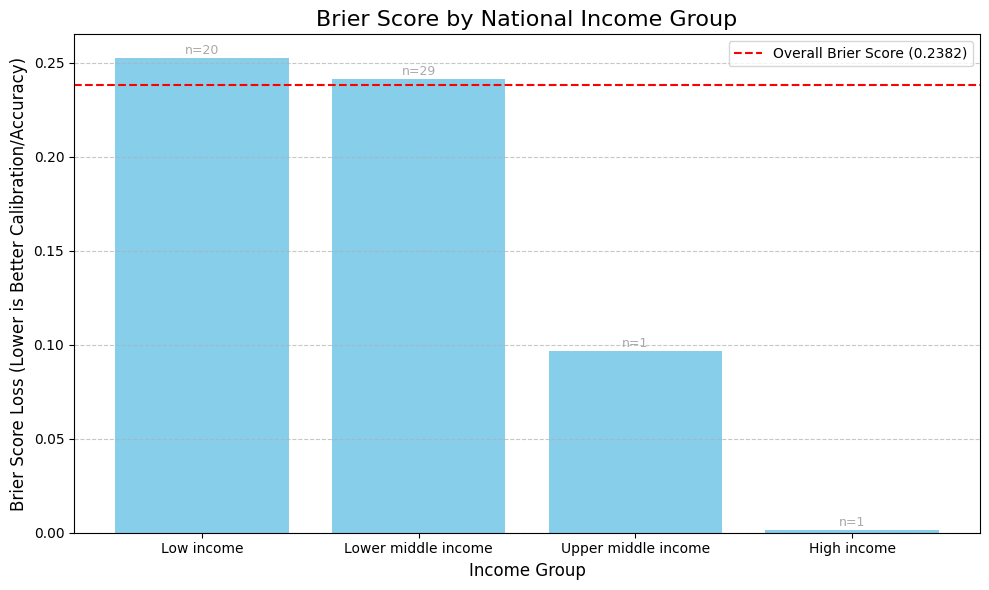

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- ASSUMPTION: df_final is loaded here. REPLACE THIS LINE with your data loading ---
# Example: df_final = pd.read_csv('your_data_file.csv')
# Since I cannot load it, the following code will produce an error until you load your data.

# Copy original dataframe
df = df_final.copy()

# ------------------------------------------------
# 1. Create binary target for calibration analysis
# ------------------------------------------------
# Define high mortality as above the median (or choose your own threshold)
threshold = df['Child_Mortality_Rate'].median()
df['High_Mortality'] = (df['Child_Mortality_Rate'] > threshold).astype(int)

# ------------------------------------------------
# 2. Select features and target
# ------------------------------------------------
X = df[['ITN_Coverage', 'ITN_Poorest', 'ITN_Richest',
        'Wealth_Gap', 'Region', 'IncomeGroup']]
y = df['High_Mortality']

categorical_cols = ['Region', 'IncomeGroup']
numeric_cols = ['ITN_Coverage', 'ITN_Poorest', 'ITN_Richest', 'Wealth_Gap']

# Preprocessing Pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# ------------------------------------------------
# 3. Random Forest Classifier
# ------------------------------------------------
rf_model = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight='balanced'  # Adjust for imbalance
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf_model)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

# ------------------------------------------------
# 4. Predictions and Overall Brier Score
# ------------------------------------------------
# Get the predicted probability of the positive class (1: High Mortality)
y_prob = pipeline.predict_proba(X_test)[:, 1]
brier_overall = brier_score_loss(y_test, y_prob)

# ------------------------------------------------
# 5. Brier Score by Subgroup (IncomeGroup)
# ------------------------------------------------
print("--- Brier Score by Subgroup (IncomeGroup) ---")

# We need the original, un-transformed X_test data for subgrouping
X_test_subgroup = X_test.copy()
X_test_subgroup['Predicted_Prob'] = y_prob
X_test_subgroup['True_Outcome'] = y_test

subgroups = X_test_subgroup['IncomeGroup'].unique()
brier_scores_by_subgroup = {}

for subgroup in subgroups:
    subgroup_data = X_test_subgroup[X_test_subgroup['IncomeGroup'] == subgroup]
    y_true_subgroup = subgroup_data['True_Outcome']
    y_prob_subgroup = subgroup_data['Predicted_Prob']

    if len(y_true_subgroup) > 0:
        brier_subgroup = brier_score_loss(y_true_subgroup, y_prob_subgroup)
        brier_scores_by_subgroup[subgroup] = brier_subgroup
        print(f"Income Group: **{subgroup}** | Count: {len(y_true_subgroup):<3} | Brier Score: {brier_subgroup:.4f}")

print(f"\nOverall Brier Score (for comparison): {brier_overall:.4f}")

# ------------------------------------------------
# 6. Plotting the Brier Score by Subgroup
# ------------------------------------------------

# Convert the results dictionary to a Pandas Series for easy plotting
brier_series = pd.Series(brier_scores_by_subgroup).sort_values(ascending=False)
subgroup_counts = X_test_subgroup['IncomeGroup'].value_counts().reindex(brier_series.index)


plt.figure(figsize=(10, 6))
bars = plt.bar(brier_series.index, brier_series.values, color='skyblue')
plt.axhline(y=brier_overall, color='red', linestyle='--', linewidth=1.5, label=f'Overall Brier Score ({brier_overall:.4f})')

# Annotate each bar with the count of observations (n)
for bar, count in zip(bars, subgroup_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'n={count}', ha='center', va='bottom', fontsize=9, color='darkgray')


plt.title('Brier Score by National Income Group', fontsize=16)
plt.xlabel('Income Group', fontsize=12)
plt.ylabel('Brier Score Loss (Lower is Better Calibration/Accuracy)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------